<a href="https://colab.research.google.com/github/Minghaooooo/Lake_Airplane/blob/main/Lake_or_airport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting Google Drive + Changing the Working Directory.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.chdir("/content/gdrive/MyDrive/ColabNotebooks/Notebooks")

# Declare the packages needed

In [ ]:
import tensorflow as tf
print('Tensorflow version: {}'.format(tf.__version__))
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pathlib

Tensorflow version: 2.15.0


# Configure data set path

In [30]:
path_root = os.path.join(os.path.realpath("."),"2_class")
data_dir = pathlib.Path(path_root)

#number of directories
image_count = len(list(data_dir.glob('*/*.jpg')))
#Show category
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])
print("number of data:{}\nCategory of the data:{}".format(image_count,CLASS_NAMES))

#%%
# Print files in this path
for item in data_dir.iterdir():
    print(item)
import random
all_image_path = list(data_dir.glob("*/*"))
all_image_path = [str(path) for path in all_image_path]
random.shuffle(all_image_path)

number of data:1400
Category of the data:['lake' 'airplane']
/content/gdrive/MyDrive/ColabNotebooks/Notebooks/2_class/lake
/content/gdrive/MyDrive/ColabNotebooks/Notebooks/2_class/airplane


# Load images

In [31]:
#%%Determine the label of each image
lable_names = sorted(item.name for item in data_dir.glob("*/"))
#Assign an index to each tag and build a dictionary
lable_to_index = dict((name,index) for index,name in enumerate(lable_names))
print(lable_to_index)
#Create a list containing the tag index of each file
all_image_label = [lable_to_index[pathlib.Path(path).parent.name] for path in all_image_path]

#Wrap it as a function for later use
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image /= 255.0  # normalize to [0,1] range
    return image
#Load images
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)



{'airplane': 0, 'lake': 1}


Example of reading an image

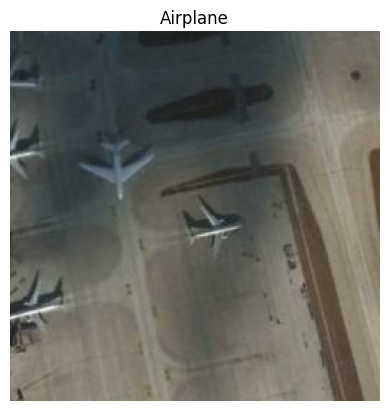

In [ ]:
image_path = all_image_path[50]
label = all_image_label[50]

plt.imshow(load_and_preprocess_image(image_path))
plt.grid(False)
##plt.xlabel(caption_image(image_path))
plt.title(lable_names[label].title())
plt.axis("off")
print()

# Image preprocessing


In [51]:

path_ds =  tf.data.Dataset.from_tensor_slices(all_image_path)
print(path_ds)

AUTOTUNE = tf.data.experimental.AUTOTUNE
image_ds = path_ds.map(load_and_preprocess_image,num_parallel_calls=AUTOTUNE)

lable_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_label,tf.int64))
for label in lable_ds.take(5):
    print(lable_names[label.numpy()])

image_label_ds = tf.data.Dataset.zip((image_ds,lable_ds))
print(image_label_ds)

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
lake
lake
lake
airplane
airplane
<_ZipDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


Set up training data and test data

In [52]:

test_count = int(image_count*0.2)
train_count = image_count - test_count
print(test_count,train_count)

train_dataset = image_label_ds.skip(test_count)
test_dataset = image_label_ds.take(test_count)

280 1120


#Training phase
Perform certain processing on the data:
1. Disruption
2. Divide it into several batches


In [53]:
batch_size = 32
# Set a shuffle buffer size consistent with the size of the data set (random buffer size) to ensure that the data is fully shuffled.
train_ds = train_dataset.shuffle(buffer_size=image_count).repeat().batch(batch_size)
test_ds = test_dataset.batch(batch_size)

Build model

In [54]:

model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64, (3, 3), input_shape=(256, 256, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling2D())

model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

#%%
model.summary()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc']
)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 254, 254, 64)      1792      
                                                                 
 conv2d_19 (Conv2D)          (None, 252, 252, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 126, 126, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 124, 124, 128)     73856     
                                                                 
 conv2d_21 (Conv2D)          (None, 122, 122, 128)     147584    
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 61, 61, 128)       0         
 ng2D)                                                

开始训练

In [55]:
steps_per_eooch = train_count//batch_size
validation_steps = test_count//batch_size

history = model.fit(train_ds,epochs=30,steps_per_epoch=steps_per_eooch,validation_data=test_ds,validation_steps=validation_steps)

Epoch 1/30
35/35 [==============================] - 19s 393ms/step - loss: 1.1798 - acc: 0.5688 - val_loss: 0.7980 - val_acc: 0.5000
Epoch 2/30
35/35 [==============================] - 13s 386ms/step - loss: 0.6624 - acc: 0.5223 - val_loss: 0.6822 - val_acc: 0.7773
Epoch 3/30
35/35 [==============================] - 14s 402ms/step - loss: 0.6429 - acc: 0.5839 - val_loss: 0.6928 - val_acc: 0.5117
Epoch 4/30
35/35 [==============================] - 13s 384ms/step - loss: 0.6393 - acc: 0.6062 - val_loss: 0.4445 - val_acc: 0.5117
Epoch 5/30
35/35 [==============================] - 13s 384ms/step - loss: 0.3352 - acc: 0.7804 - val_loss: 0.1149 - val_acc: 0.9609
Epoch 6/30
35/35 [==============================] - 13s 385ms/step - loss: 0.1775 - acc: 0.9446 - val_loss: 0.1415 - val_acc: 0.9531
Epoch 7/30
35/35 [==============================] - 13s 374ms/step - loss: 0.1770 - acc: 0.9536 - val_loss: 0.1945 - val_acc: 0.9453
Epoch 8/30
35/35 [==============================] - 13s 384ms/step - 

Results


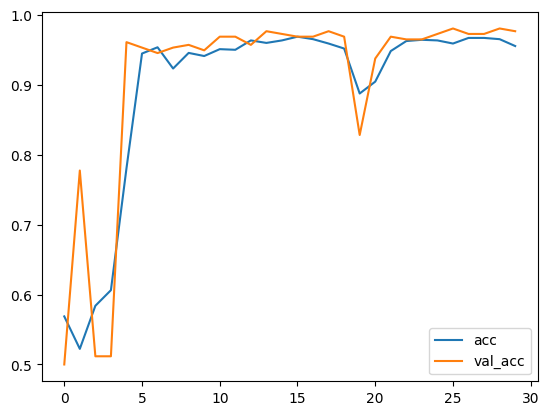

In [56]:
history.history.keys()
plt.plot(history.epoch, history.history.get('acc'), label='acc')
plt.plot(history.epoch, history.history.get('val_acc'), label='val_acc')
plt.legend()
plt.show()


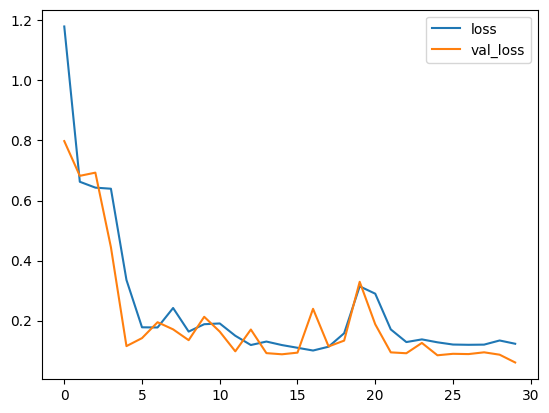

In [57]:
plt.plot(history.epoch, history.history.get('loss'), label='loss')
plt.plot(history.epoch, history.history.get('val_loss'), label='val_loss')
plt.legend()


Save model

In [ ]:
model.save("/content/gdrive/Othercomputers/Mycomputer/GoogleDrive")


# Prediction for a single image


/!\ /!\ /!\

In [62]:
def predict_and_print(image_path):
    # 1. Read image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, (256, 256))  # Resize the image to (256, 256)

    # 2. Ensure the shape is (1, 256, 256, 3)
    image = tf.expand_dims(image, axis=0)

    # # 3. Load the pre-trained model
    # model = tf.keras.models.load_model(model_path)

    # 4. Predict
    predictions = model.predict(image)
    # print(predictions)

    # 5. Process the prediction result
    predicted_class = predictions[0][0]


    if predicted_class == 1:
        plt.imshow(load_and_preprocess_image(image_path))
        plt.title('Predict: Lake')
        plt.axis("off")
        print()
    else:
        plt.imshow(load_and_preprocess_image(image_path))
        plt.title("Predict: Airplane")
        plt.axis("off")
        print()



1/1 [==============================] - 0s 20ms/step



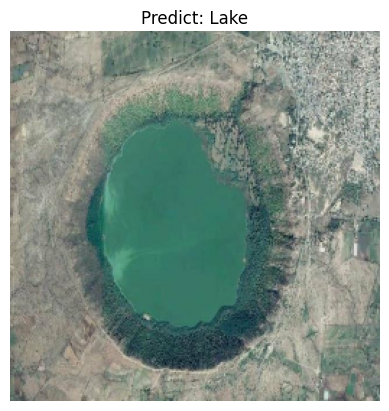

In [63]:
# Example usage:
image_path = 'Lake_Airplane_test/Lake02.png'
# model_path = 'your_model_path'  # Replace with the path to your saved model
predict_and_print(image_path)
